# Deep Learning &mdash; Assignment 12

Assignment for week 12 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Implement GradCAM
2. Investigate the important features for certain inputs.
3. Ingestigate variants of GradCAM

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [1]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

import os
from d2l import torch as d2l
import PIL
import urllib.request
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io.image import read_image

device = d2l.try_gpu()

## 12.1 A pretrained network (4 points)

In this assignment we will be working with a pre-trained network.
These are available in torchvision. Look at [the documentation](https://pytorch.org/vision/stable/models.html) for more information on pretrained models.

In this assignment we will use the ResNet50 model.

**(a) Load a pretrained ResNet50 model, with default weights**

In [2]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Next we will download a couple of random images, which we will use for the rest of this notebook.

**(b) Run the code below to download the test images**

In [3]:
# Download some images
urls = [
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'https://farm8.staticflickr.com/7020/6810252887_01e3d8e4e6_z.jpg',
    'http://images.cocodataset.org/val2017/000000039769.jpg',
    'http://images.cocodataset.org/train2017/000000140285.jpg',
    # Some mroe images to play around with
    'https://farm1.staticflickr.com/35/67223286_72fce12163_z.jpg',
    'https://farm4.staticflickr.com/3587/3508226585_268a2e5b9b_z.jpg',
    'https://farm1.staticflickr.com/6/6947166_ba80959bbb_z.jpg',
    'https://farm3.staticflickr.com/2325/5821134041_b96fef0946_z.jpg',
    'https://farm1.staticflickr.com/115/296513905_ddb2cf6438_z.jpg',
    'https://farm8.staticflickr.com/7020/6810252887_01e3d8e4e6_z.jpg',
]

def load_url(url):
    filename = os.path.basename(url)
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
    return read_image(filename)

images = [load_url(url) for url in urls]

The code below shows these images.

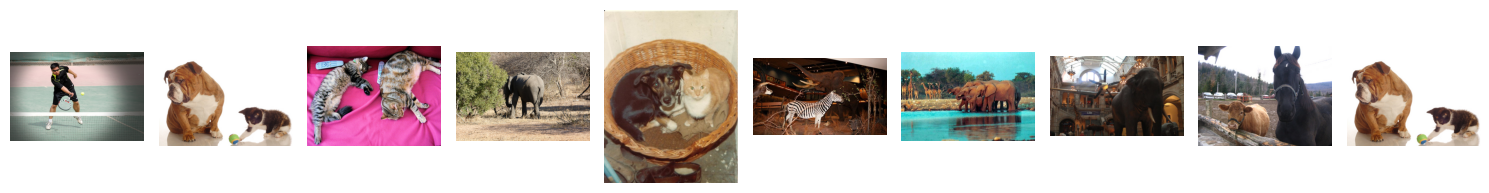

In [4]:
plt.figure(figsize=(15,15))
for i, image in enumerate(images):
    plt.subplot(1,len(images), i+1)
    plt.imshow(transforms.ToPILImage()(image))
    plt.axis('off')
plt.tight_layout()

The pretrained model was trained with a specific image preprocessing. So we should use the same:

In [5]:
preprocess = weights.transforms()

**(c) Preprocess the images, and store them in a single tensor.<span style="float:right"> (1 point)</span>**

Hint: [`torch.stack`](https://pytorch.org/docs/stable/generated/torch.stack.html) can be useful.

Note: you may get a warning about parameters of transform, you can ignore it.

In [6]:
x = torch.stack([preprocess(image) for image in images], dim=0)

# Verify that the batch has the right shape
assert(x.shape == torch.Size([len(images), 3, 224, 224]))

/lustre/home/lmucko/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


It is also useful to be able to undo the preprocessing, at least the normalization and the dimension permutation, so that we can plot the preprocessed images as well.

In [7]:
def unnormalize(x):
    """Make a preprocessed image showable."""
    x = torch.permute(x, [1,2,0]) # Make the color channels the last dimension
    x = x * torch.tensor(preprocess.std)[None,None,:]
    x = x + torch.tensor(preprocess.mean)[None,None,:]
    return x

**(d) Plot the pre-processed images**

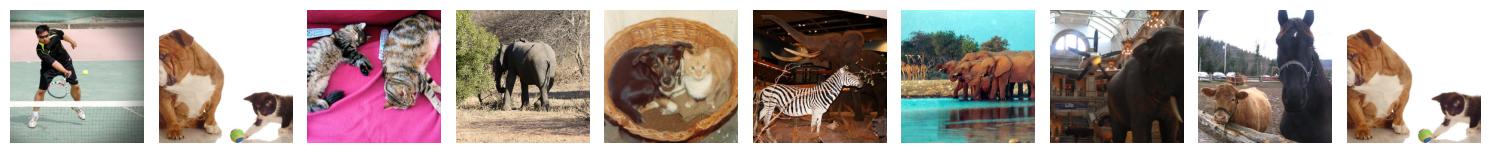

In [8]:
plt.figure(figsize=(15,15))
for i, image in enumerate(x):
    plt.subplot(1,len(x), i+1)
    plt.imshow(unnormalize(image.cpu()))
    plt.axis('off')
plt.tight_layout()

**(e) Compare the preprocessed images to the original. How does the default preprocessing make all the images the same size?**

It crops the images as we can see in the cat and dog image.

**(f) Run the classifier on the batch of images.<span style="float:right"> (1 point)</span>**

In [9]:
y = model(x.to(device))

The classifier predicts a logit scores, represing the likelihood of 1000 classes.

You can use the [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html) function to get a list of the predicted labels with the highest score. This function returns a tuple with two elements, `result.indices` is the indices, and `result.values` contains the correspondig scores.

By themselves, these indices don't tell you what the predicted class actually is. For that you can use the following function:

In [10]:
def category(index):
    """Return the textual category for some predictions"""
    return np.array(weights.meta["categories"])[index]

**(g) Create a table with the textual label for the top 5 predicted labels for each image.<span style="float:right"> (1 point)</span>**

Hint: [`pd.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) is an easy way of producing a nice looking table.

In [11]:
values, indices = torch.topk(y, k=5, dim=1)
data = {}
for i, image in enumerate(images):
    top_labels = [category(idx.item()) for idx in indices[i]]
    data[f"image {i}"] = top_labels
    
df = pd.DataFrame(data).T
df.columns = [f'Top_Label_{i + 1}' for i in range(len(values[0]))]
print(df)

                            Top_Label_1  Top_Label_2  \
image 0                          racket  tennis ball   
image 1  American Staffordshire terrier        boxer   
image 2                           tabby    tiger cat   
image 3                African elephant       tusker   
image 4                          hamper  Appenzeller   
image 5                           zebra  triceratops   
image 6                African elephant       tusker   
image 7                 Indian elephant       tusker   
image 8                      worm fence           ox   
image 9  American Staffordshire terrier        boxer   

                       Top_Label_3         Top_Label_4      Top_Label_5  
image 0             ping-pong ball              dugong       volleyball  
image 1  Staffordshire bullterrier        bull mastiff      tennis ball  
image 2               Egyptian cat      remote control     sleeping bag  
image 3            Indian elephant             warthog         broccoli  
image 4      

**(h) Are there any strange labels in the top 5 predictions for any of the images?<span style="float:right"> (1 point)</span>**

There are some strange labels, produced by some wrong predictions. For examples: in the image 5 it detects (as label 2) a triceratops instead of a elephant; another error is on image 0 where it detects a dugong (as label 4).

## 12.2 Hooking into the network (4 points)

To understand and visualize which part of the images are 'causing' the predicted labels, we can use [GradCAM](https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf).

GradCAM needs to know the activations and output gradients of the last layer in the model, just before the global pooling layer. The activations are computed during forward propagation (`model.forward()`), and the gradients are computed when calling `y.backward()`, but neither of them are saved anywhere.

To capture the activations and gradients we need to use hooks, which allow us to register a function that gets called every time a module's `forward` or `backward` function is called.

Take a look at
[`torch.Module.register_forward_hook`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook) and [`torch.Module.register_full_backward_hook`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook).

**(a) Complete the code below.<span style="float:right"> (2 points)</span>**

You can store the activations and gradients as a member variable of the layer, or you can use a global variable.

In [16]:
layer_activations = None
layer_gradients = None

def add_hooks(layer):
    """
    Add hooks to a layer that store the activations (the output of the layer) in the forward pass,
    as well as the gradient wrt. the output in the backward pass
    """
    def forward_hook(layer, args, output):
        # This function will be called after the forward pass.
        #   args are the inputs of the layer
        #   output is the output of the layer
        
        # TODO: store activations
        global layer_activations
        layer_activations = output.clone().detach()


    def backward_hook(layer, grad_input, grad_output):
        # This function is called after the backward pass
        #   grad_input is a *tuple* that contains the gradients wrt the inputs.
        #   grad_output is a *tuple* the gradient the gradients wrt the outputs.
        pass # TODO: store gradients
        global layer_gradients
        layer_gradients = grad_output[0].clone().detach().requires_grad_(True)

    # Remove old hooks (if any)
    remove_hooks(layer)
    
    # Register new hooks
    layer.forward_hook  = layer.register_forward_hook(forward_hook)
    layer.backward_hook = layer.register_full_backward_hook(backward_hook)

def remove_hooks(layer):
    if hasattr(layer,'forward_hook'):
        layer.forward_hook.remove()
    if hasattr(layer,'backward_hook'):
        layer.backward_hook.remove()

**(b) Which layer of the ResNet50 model should the hooks be applied to?<span style="float:right"> (1 point)</span>**

Hint: you can `print` a model, and you can access a named layer using `model.layer`

In [17]:
hooked_layer = list(model.children())[-3] # layer just before global pooling

**(c) Add the hooks to the layer.<span style="float:right"> (no points)</span>**

In [18]:
add_hooks(hooked_layer)

**(d) Verify that the hooks work, by completing and running the code below.<span style="float:right"> (1 point)</span>**

In [19]:
y = model(x[[0]].to(device)) # TODO: run model forward on the first image, x[[0]]
top_class = torch.argmax(y) # TODO: get the top class with torch.argmax
# TODO: run model backward for the logit of top predicted class
y[0, top_class].backward()
layer_activations = layer_activations # TODO: get stored activations
layer_gradients = layer_gradients   # TODO: get stored gradients
model.zero_grad() #To avoid accumulation of gradients

assert layer_activations.shape[1:] == torch.Size([2048, 7, 7]), "Activations has the wrong shape. Maybe you did not add hooks to the last layer before global pooling."
assert layer_gradients.shape == layer_activations.shape, "Gradients have the wrong shape. Make sure to use the output gradients, and note that grad_output is a tuple."
assert torch.mean(layer_activations) != 0, "Activations should not be zero"
assert torch.mean(layer_gradients) != 0, "Gradients should not be zero"
assert torch.mean(layer_activations - layer_gradients) != 0, "Gradients should not be the same as the activations"
assert top_class == 752, "Did you use the right image"

## 12.3 GradCAM (9 points)

Now we are ready to implement GradCAM.

**(a) GradCAM uses 'neuron importance weights', based on the gradients. Compute these importance weights.<span style="float:right"> (1 point)</span>**

See equation (1) of [the paper](https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf).

In [20]:
importance_weights = torch.mean(layer_gradients, dim=(2,3))

assert importance_weights.squeeze().shape == torch.Size([2048])

**(b) Combine the importance weights with the activations to get the gradcam map.<span style="float:right"> (2 point)</span>**

See equation (2) of [the paper](https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf).

Hint: To combine two tensors they need to have the same shape. You can make them line up by adding new dimensions to a tensor using `tensor[:,None,:,None]`, where `None` is a new dimension, while `:` is an existing dimension.

In [21]:
gradcam_map = torch.relu(torch.sum(layer_activations * importance_weights[:,:,None,None], dim=1).squeeze())
assert gradcam_map.shape == torch.Size([7, 7])
assert torch.min(gradcam_map) >= 0

**(c) Plot the gradcam map.**

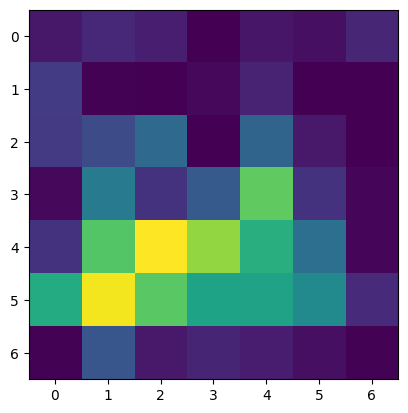

In [22]:
plt.imshow(gradcam_map.detach().cpu());

We can resize the map using interplation to make it smoother, and to align it with the input image.

**(d) Plot the resized and smoothed GradCAM map.**

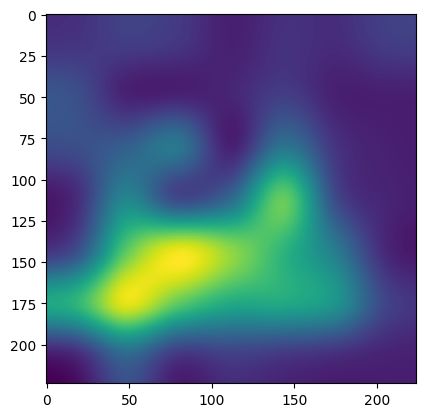

In [23]:
def resize_map(map, size=(224,224)):
    return np.asarray(to_pil_image(map.detach().cpu(),'F').resize(size))

plt.imshow(resize_map(gradcam_map));

**(e) Overlay the gradcam map over the input image.<span style="float:right"> (1 point)</span>**

You can overlay two images by drawing the second one semi-transparent with `alpha=0.5`.

Expected output: the highlighted region should correspond to the predicted label.
Although the alignment might be slightly off.

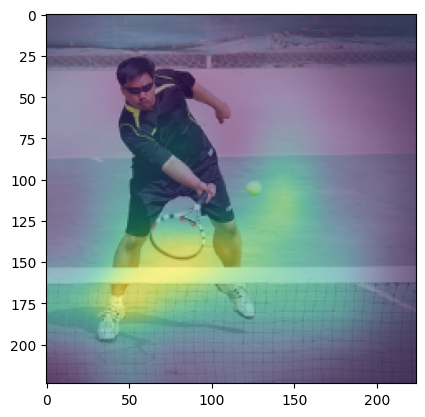

In [24]:
plt.imshow(unnormalize(x[0].cpu()));
plt.imshow(resize_map(gradcam_map), alpha=0.5);

We needed several steps to compute a gradCAM visualisation. Let's clean up the code by encapsulating it in a function.

**(f) Complete the code below.<span style="float:right"> (1 point)</span>**

Hint: the model always works on a batch of images, you can turn a single image into a batch by adding a new dimension, `image[None]`.

In [33]:
def gradcam(image, index, model=model, device=device):
    """
    Compute a GradCAM map for the given input image, and class index.
    """
    global layer_activations, layer_gradients
    y = model(image[None].to(device))
    y[0, index].backward()
    layer_activations = layer_activations # TODO: get stored activations
    layer_gradients = layer_gradients   # TODO: get stored gradients
    model.zero_grad() #To avoid accumulation of gradients
    importance_weights = torch.mean(layer_gradients, dim=(2,3))
    gradcam_map = torch.relu(torch.sum(layer_activations * importance_weights[:,:,None,None], dim=1).squeeze())
    return gradcam_map

assert torch.any(gradcam(x[0],0) != gradcam(x[1],0)), "Are you using the incorrect global variables?"
assert torch.all(gradcam(x[0],0) == gradcam(x[0],0)), "Calling the function twice gives different results, perhaps some gradients are not cleared?"

**(g) Complete the code below to create a class activation map for the top 5 label for each of the images.<span style="float:right"> (2 point)</span>**

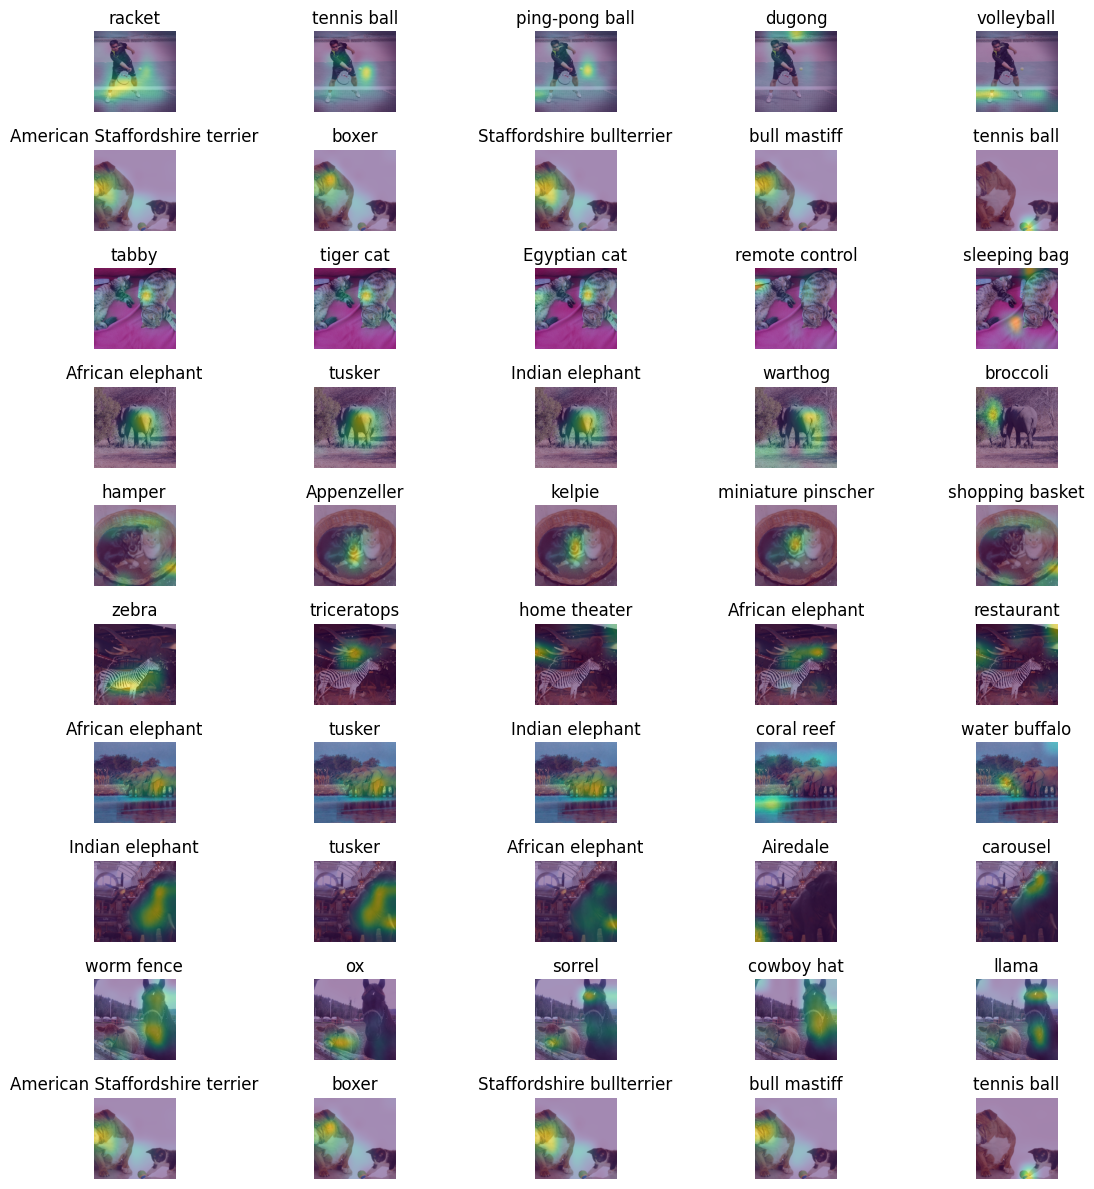

In [34]:
plt.figure(figsize=(12,12))
for i, image in enumerate(x):
    top5_indices = indices[i]
    for j, index in enumerate(top5_indices):
        plt.subplot(len(images),5, i*5 + j + 1)
        # TODO: compute and plot gradcam map, overlayed on the image
        gradcam_map = gradcam(image, index)
        plt.imshow(unnormalize(image.cpu()))
        plt.imshow(resize_map(gradcam_map), alpha=0.5)
        # TODO: set title to label of the class index
        plt.title(category(index))
        plt.title(...)
        plt.title(category(index))
        plt.axis('off')
plt.tight_layout()

**(h) Do the gradcam maps make sense? Do the highlighted areas roughly correspond to the location of objects in the image? Mention specific examples.<span style="float:right"> (1 point)</span>**

For the best labels they do make sense and the highlighted area is mostly in the correct spot. For example the location of "zebra" is on the object of zebra in the image, racket is on the racket etc. Some objects are incorrectly highlighted such as "worm fence" on a horse.

**(i) Do the highlighted areas correspond *exactly* to the location of objects in the image? Why / why not?<span style="float:right"> (1 point)</span>**

No, since the highlighted area "shifted" due to interpolation to a higher dimension. The general shape should still be conserved.

## 12.4 Variants (7 points)

GradCAM includes a non-linear activation function. The result is that the GradCAM map that is produced only contains positive values. But perhaps the negative values also contain useful information?

**(a) Copy and modify the code from part 12.3f and g, by negating the input to the non-linearity.<span style="float:right"> (1 point)</span>**

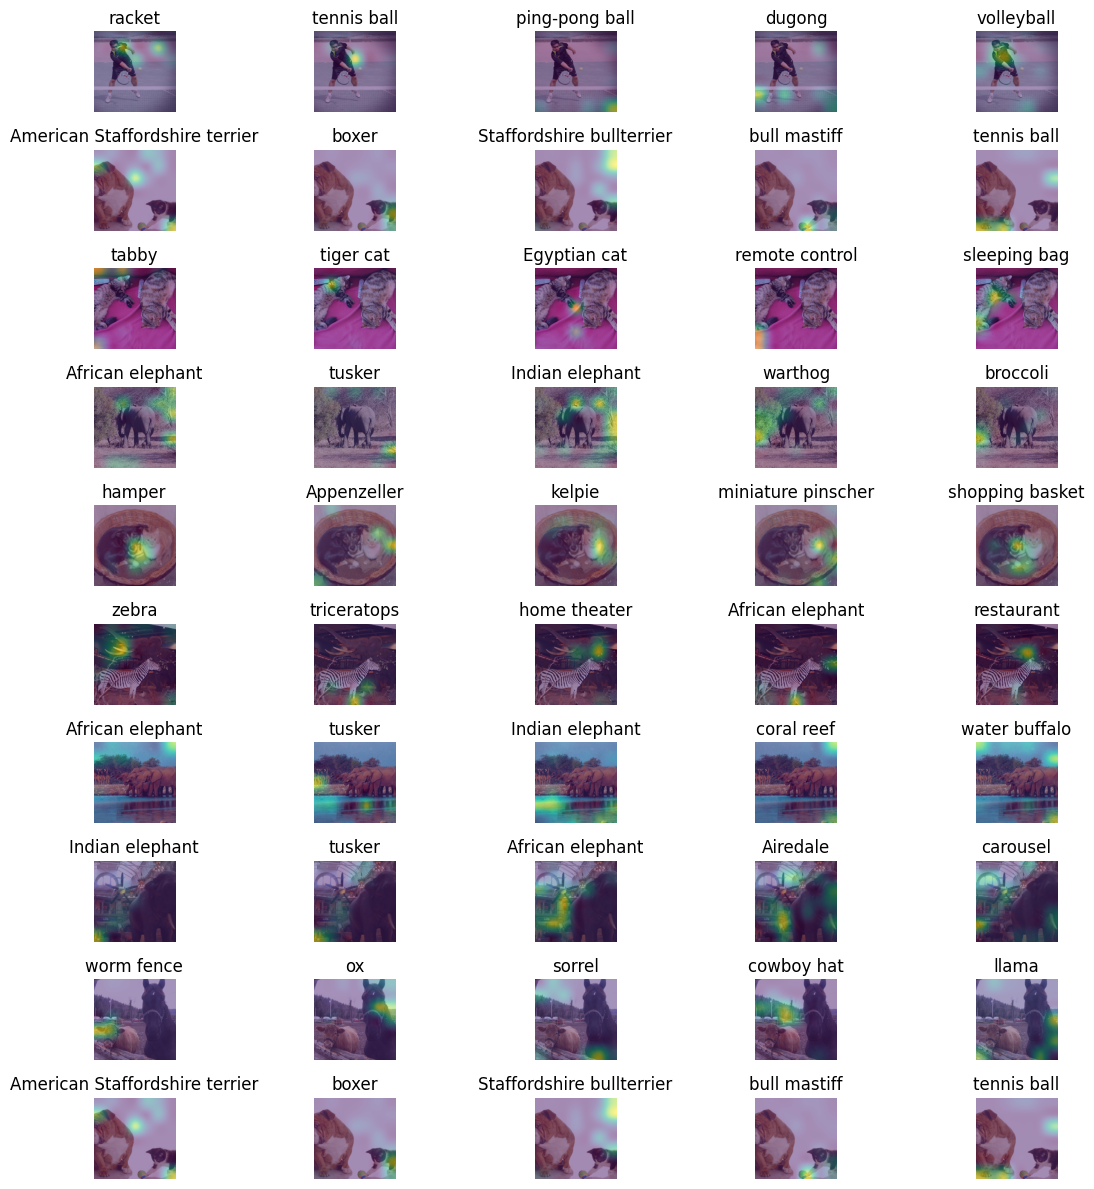

In [27]:
def gradcam_negative(image, index):
    global layer_activations, layer_gradients
    y = model(image[None].to(device))
    y[0, index].backward()
    layer_activations = layer_activations # TODO: get stored activations
    layer_gradients = layer_gradients   # TODO: get stored gradients
    model.zero_grad() #To avoid accumulation of gradients
    importance_weights = torch.mean(layer_gradients, dim=(2,3))
    gradcam_map = torch.relu(-torch.sum(layer_activations * importance_weights[:,:,None,None], dim=1).squeeze())
    return gradcam_map

assert torch.all((gradcam(x[0],123) > 0) != (gradcam_negative(x[0],123) > 0)), "The negative and positive GradCAM can not be active in the same locations of the image"

plt.figure(figsize=(12,12))
for i, image in enumerate(x):
    top5_indices = indices[i]
    for j, index in enumerate(top5_indices):
        plt.subplot(len(images),5, i*5 + j + 1)
        # TODO: compute and plot gradcam map, overlayed on the image
        gradcam_map = gradcam_negative(image, index)
        plt.imshow(unnormalize(image.cpu()))
        plt.imshow(resize_map(gradcam_map), alpha=0.5)
        # TODO: set title to label of the class index
        plt.title(category(index))
        plt.title(...)
        plt.title(category(index))
        plt.axis('off')
plt.tight_layout()

**(b) What are the areas that are highlighted now?<span style="float:right"> (1 point)</span>**

The areas highlighted are the ones that the model considers least important for the classification of the given label.

**(c) Plot the negative gradcam map for the bottom 5 predictions instead of the top 5.<span style="float:right"> (1 point)</span>**

Hint: the bottom 5 of `x` is the top 5 of `-x`.

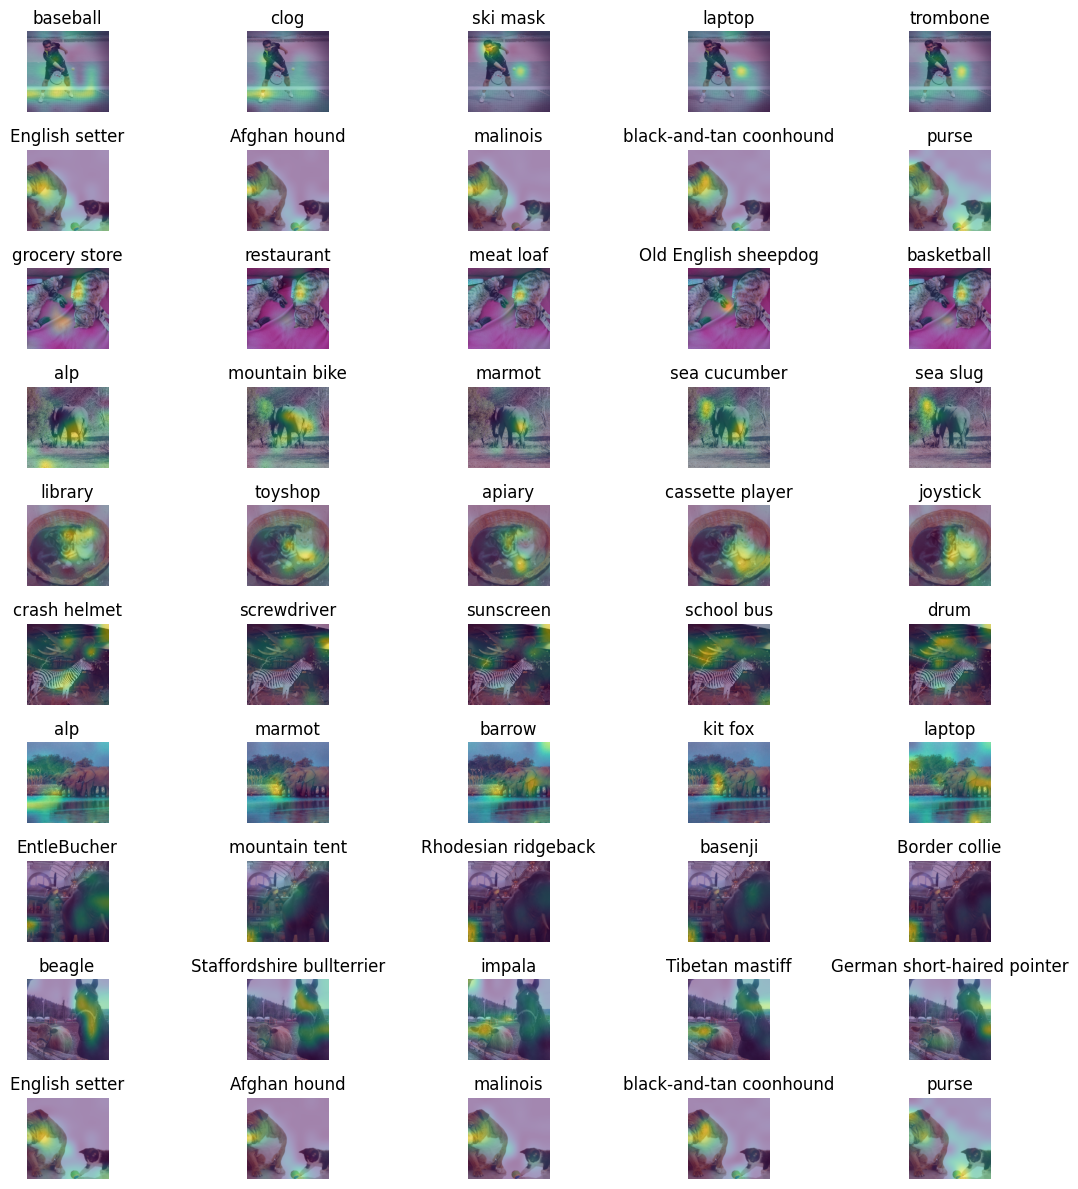

In [28]:
plt.figure(figsize=(12,12))
for i, image in enumerate(x):
    _, bottom_5_indices = torch.topk(-model(image[None].to(device)), k=5)
    bottom_5_indices = bottom_5_indices.squeeze().to("cpu")
    for j, index in enumerate(bottom_5_indices):
        plt.subplot(len(images),5, i*5 + j + 1)
        # TODO: compute and plot gradcam map, overlayed on the image
        gradcam_map = gradcam_negative(image, index)
        plt.imshow(unnormalize(image.cpu()))
        plt.imshow(resize_map(gradcam_map), alpha=0.5)
        # TODO: set title to label of the class index
        plt.title(category(index))
        plt.title(...)
        plt.title(category(index))
        plt.axis('off')
plt.tight_layout()

**(d) What can you learn from these maps? Give at least 1 concrete example.<span style="float:right"> (1 point)</span>**

Plotting the negative gradcam highlights the areas that the model considers least important for classification of the best labels. <br/>
Plotting the negative gradcam with worst performing labels highlights the areas that the model considers least important for those incorrect classification, but those hotspots are mostly located on the most recognizable object on the image i.e. "Beagle" on a horse, "Library" on cat and dog etc.

Instead of looking at the last layer before global pooling, we could in theory also apply GradCAM at a different layer of the network. Perhaps that can give a higher resolution map?

**(e) Adapt the gradcam code to take the model and layer of the model as parameters <span style="float:right"> (1 point)</span>**

Note: you may need to add hooks at this point.

In [31]:
def gradcam_at(model, layer, image, index):
    """
    Compute a GradCAM map at the given layer of the given model
    """
    global layer_activations, layer_gradients
    layer_activations, layer_gradients = None, None
    add_hooks(layer)
    gradcam_map = gradcam(image, index, model=model)
    remove_hooks(layer)
    return gradcam_map

**(f) Now use gradcam at an intermediate layer of the model <span style="float:right"> (1 point)</span>**

In [74]:
new_model = resnet50(weights=weights).to(device)
gradcam_map = gradcam_at(new_model, new_model.layer2, torch.clone(x[0]), 752)

assert gradcam_map.shape != torch.Size([7,7]), "Use a different layer"

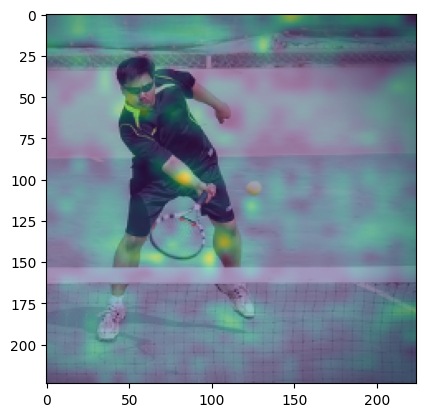

In [76]:
plt.imshow(unnormalize(x[0].cpu()));
plt.imshow(resize_map(gradcam_map), alpha=0.5);

**(g) Do the gradcam maps for this earlier layer give a useful visualization?<span style="float:right"> (1 point)</span>**

No, nothing sensible can be inferred from this visualization. The further deep we go into the netork the better the visualization is and vice-versa.

## 12.5 Of cats and dogs (5 points)

For the second image (`images[1]`, the one with the white background), there is an object that is clearly in the image, but it does not appear in the top 5 classes.

**(a) Why is this object not detected in the top 5?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(b) How could you reduce the bias of the model for the second image, to make it also detect the other object?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(c) Curuously, for this second image, the bottom 5 labels for this image also include dogs. Why would that happen?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(d) Create a GradCAM map for the missing object in the image.<span style="float:right"> (1 point)</span>**

Hint: The third images contains some labels that you can use.
You can also use the following function to get the corresponding class index.

In [ ]:
def find_category(query):
    """Find a category that has or contains the given name."""
    found = [i for (i,k) in enumerate(weights.meta["categories"]) if k.find(query)!=-1]
    if len(found) == 1:
        return found[0]
    elif len(found) > 1:
        raise Exception("Multiple categories found: " + str(category(found)))
    else:
        raise Exception("No category found that matches: " + str(query))

In [ ]:
# TODO: Make a gradcam map for another class

**(e) Are you able to find this object when you go looking for it? Explain your answer briefly.<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 29 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 3770c63 / 2023-12-04</span>